## Toy example
Example notebook to experiment with fire potential polygons from "*Modeling Fire Potential Networks for Suppression Strategies Using Fire Spread Simulations and Hydrological Tools*"

- Author: Minho Kim
- Date: Jan 2025

In [1]:
import os, sys, subprocess
import rasterio
import numpy as np
import pandas as pd
import contextily as ctx
from shapely.geometry import box

import pyflwdir
from pyflwdir.dem import *

In [2]:
# 1. Link to Cell2Fire's location
sys.path.append('/Users/minho/Desktop/Projects/suppression_networks/barcelona_work/paper/C2F-W')

# 2. Link to custom paths
sys.path.append('../src')
from network import *
from geomorphology_utils import *

In [3]:
# Set main paths and parameters
base_path = '/Users/minho/Documents/GitHub/firepolygons'
infolder = os.path.join(base_path, 'data/toy_example')
outfolder = os.path.join(base_path, 'results/toy_example')

if not os.path.exists(infolder):
    os.mkdir(infolder)
if not os.path.exists(outfolder):
    os.mkdir(outfolder)

CRS_LATLON = 4326
CRS_UTM = 25831

## Data Preprocessing

#### Create fuel map

In [4]:
# Create a 100 x 100 synthetic landscape with homogeneous fuels 
fuel_type = 101
width, height = (50,50)

fuels = np.ones((width, height)) * fuel_type

In [5]:
from pyproj.crs import CRS
from affine import Affine

# Create metadata
meta = {'driver': 'GTiff', 
        'dtype': 'uint16', 
        'nodata': None, 
        'width': width, 
        'height': height, 
        'count': 1, 
        'crs': CRS.from_epsg(CRS_UTM)}

transform = Affine(20.0, 0.0, 333152.38261041, 0.0, -20.0, 4652695.6527613) # Default
meta['transform'] = transform

In [6]:
# Save fuels raster
with rasterio.open(os.path.join(infolder, 'fuels.tif'), 'w', **meta) as dst:
    dst.write(fuels, 1)

#### Create elevation map

In [7]:
# Create a 100 x 100 synthetic landscape with no topography (no elevation no slope)
elevation = np.zeros((width, height))

with rasterio.open(os.path.join(infolder, 'elevation.tif'), 'w', **meta) as dst:
    dst.write(elevation, 1)

#### Preprocess inputs

In [8]:
def geotiff_to_ascii(inpath):

    # Set output ASCII filename
    outpath = inpath.replace('tif', 'asc')

    # Load input GeoTIFF
    with rasterio.open(inpath, 'r') as src:
        data = src.read(1)
        meta = src.meta.copy()

    NODATA_value = meta['nodata']
    ncols = meta['width']
    nrows = meta['height']
    cellsize = meta['transform'][0]
    xllcorner = meta['transform'][2]
    yllcorner = meta['transform'][5]

    # Output ASCII
    with open(outpath, 'w') as f:
        f.write(f'ncols {ncols}\n')
        f.write(f'nrows {nrows}\n')
        f.write(f'xllcorner {xllcorner}\n')
        f.write(f'yllcorner {yllcorner}\n')
        f.write(f'cellsize {cellsize}\n')
        f.write(f'NODATA_value {NODATA_value}\n')
        np.savetxt(f, data, fmt='%d')

In [9]:
# Convert geotiff to ASCII
geotiff_to_ascii(os.path.join(infolder, 'fuels.tif'))
geotiff_to_ascii(os.path.join(infolder, 'elevation.tif'))

#### Load weather and ignition point

In [10]:
# Weather
weather_path = os.path.join(infolder, 'Weather.csv')

weather = pd.read_csv(weather_path)
weather.columns = ['Instance', 'Time', 'Wind Speed [km/h]', 'Wind Direction [degree]', 'Scenario']

weather

,Instance,Time,Wind Speed [km/h],Wind Direction [degree],Scenario
0,Sim,8/9/24 14:00,10,90,3
1,Sim,8/9/24 15:00,10,90,3
2,Sim,8/9/24 16:00,10,90,3
3,Sim,8/9/24 17:00,10,90,3
4,Sim,8/9/24 18:00,10,90,3


In [11]:
# Ignition
row = 25
col = 15

# XY coordinate to index
def coord_to_idx(row, col, ncols):
    return row * ncols + col

ig_id = coord_to_idx(row=row, col=col, ncols=meta['width'])
print("Index: ", ig_id)

Index:  1265


In [12]:
# Create CSV file
ignition_points = pd.DataFrame({'Year':[], 'NCell':[]})
ignition_points['NCell'] = [ig_id]
ignition_points['Year'] = [2024]

ignition_points.to_csv(os.path.join(infolder, 'Ignitions.csv'), index=None)

## Run Cell2Fire simulation

In [13]:
# Import C2F
sys.path.append('../C2F-W')
from Cell2Fire import DataGeneratorC as DataGenerator

In [14]:
# C2F parameters
mc_scenario = 3        # Moisture content scenario based on Scott & Burgan (2005) 
ignition_radius = 1    # Ignition radius (number of adjacent cells) to consider
reset = True           # Boolean flag to reset input data (Re-create Data.csv)
verbose=False          # Boolean flag for verbosity
# Setup input arguments
execArray, dataName = c2f_parameters(c2f_path='/Users/minho/Desktop/Projects/suppression_networks/barcelona_work/paper/C2F-W',
                                    infolder=infolder, 
                                    outfolder=outfolder, 
                                    reset=reset,
                                    igradius=ignition_radius,
                                    scenario=mc_scenario,
                                    allow_cros=True,
                                    hfactor=1.0,
                                    ffactor=1.0,
                                    bfactor=1.0,
                                    efactor=1.0,
                                    out_cfb=True,
                                    out_sfb=True,
                                    trajectories=False,
                                    verbose=verbose)  

# Create output folder and log file
if outfolder is not None:
    if os.path.isdir(outfolder) is False:
        os.makedirs(outfolder)
    LogName = os.path.join(outfolder, "LogFile.txt") # Output log
    
# Call and run C2F
with open(LogName, 'w') as output:
    proc = subprocess.Popen(execArray, stdout=output)
    proc.communicate()
proc.wait()

/Users/minho/Desktop/Projects/suppression_networks/barcelona_work/paper/C2F-W/Cell2Fire/DataGeneratorC.py:98: RuntimeWarning: invalid value encountered in cast
  CoordCells = np.empty([len(grid)*(tcols), 2]).astype(int)
/Users/minho/Desktop/Projects/suppression_networks/barcelona_work/paper/C2F-W/Cell2Fire/DataGeneratorC.py:228: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See th

0

## Cell2Fire Results

In [15]:
# Input parameters from metadata
fuels_src = rasterio.open(os.path.join(infolder, 'fuels.tif'))
fuels_extent = np.array(fuels_src.bounds)[[0, 2, 1, 3]]

In [16]:
# Collect C2F simulation output paths (ASCII files)
ros_results_path = glob.glob(os.path.join(outfolder, 'RateOfSpread', '*.asc'))
fl_results_path = glob.glob(os.path.join(outfolder, 'FlameLength', '*.asc'))
fi_results_path = glob.glob(os.path.join(outfolder, 'Intensity', '*.asc'))

# Load simulation output layers
img_shape = (meta['height'], meta['width'])

ros_avg = np.zeros((img_shape))
fl_avg = np.zeros((img_shape))
fi_avg = np.zeros((img_shape))

for i in range(len(ros_results_path)):
    ros_image = np.loadtxt(ros_results_path[i], skiprows=6)
    fl_image = np.loadtxt(fl_results_path[i], skiprows=6)
    fi_image = np.loadtxt(fi_results_path[i], skiprows=6)
    
    ros_avg += ros_image
    fl_avg += fl_image
    fi_avg += fi_image    

In [17]:
# Load the messages which contain the fire's arrival as index numbers
df = pd.read_csv(os.path.join(outfolder, 'Messages/MessagesFile1.csv'), header=None)
df.columns = ['source', 'target', 'time', 'ros', 'fli', 'fl']

# Function to convert index to row and column
def index_to_row_col(index, num_rows, num_columns):
    row = (index - 1) // num_columns
    col = (index - 1) % num_columns
    return row, col

# Convert index numbers to row, col based on the target node (i.e., fire's arrival)
num_rows, num_columns = ros_avg.shape
df[['row', 'column']] = df['target'].apply(lambda x: pd.Series(index_to_row_col(x, num_rows, num_columns)))

# Group records of fire ignitions and find the first value (minimum)
df['rc'] = df.apply(lambda row: f"{row['row']}_{row['column']}", axis=1)
df_grouped = df.groupby('rc').min()

# Fill the 2D array with the 'time' values
time = np.full((num_rows, num_columns), np.nan)

# Reshape to 2D array
for _, row in df_grouped.iterrows():
    time[int(row['row']), int(row['column'])] = row['time']

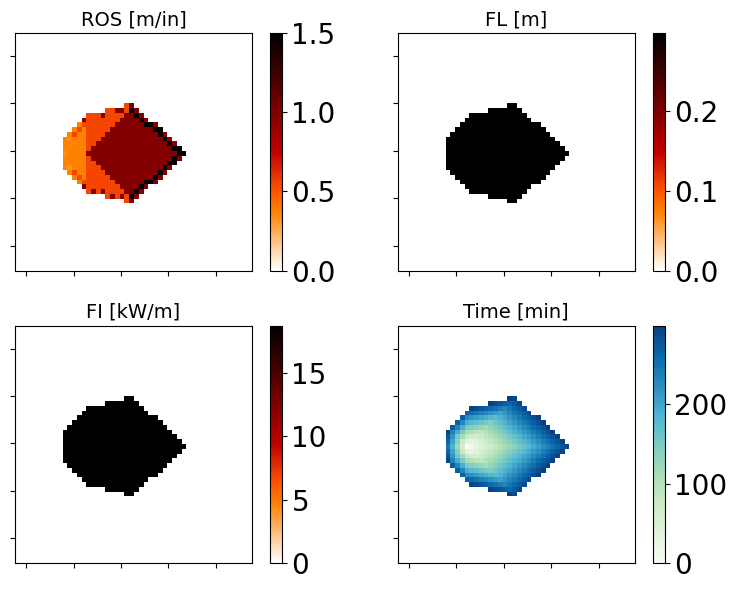

In [18]:
# Plot C2F outputs
fig, axs = plt.subplots(2,2, figsize=(8,6))

axs = axs.flatten()
cmap = ['gist_heat_r', 'gist_heat_r', 'gist_heat_r', 'GnBu']

for idx, (img, title) in enumerate(zip([ros_image, fl_image, fi_image, time], 
                                        ['ROS [m/in]', 'FL [m]', 'FI [kW/m]', 'Time [min]'])):
    
    # if idx == 0:
        # img = img * (60 / 100) # Convert from m/min to km/hr for ROS

    im=axs[idx].imshow(img, cmap=cmap[idx], vmin=0, extent=fuels_extent)
    axs[idx].set_title(title, size=14)
    cbar=plt.colorbar(im, ax=axs[idx])
    cbar.ax.tick_params(labelsize=20)  # Increase tick label size
    # axs[idx].set_xticklabels([]);axs[idx].set_yticklabels([])
    axs[idx].set_xticklabels([]);axs[idx].set_yticklabels([])

plt.tight_layout()
plt.show()

In [19]:
# Save elapsed time
with rasterio.open(os.path.join(outfolder, 'time.tif'), 'w', **meta) as dst:
    dst.write(time, 1)

/Users/minho/Desktop/Projects/suppression_networks/barcelona_work/paper/firepolygons/lib/python3.10/site-packages/numpy/core/_asarray.py:126: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


## Network modeling of fire propagation

In [20]:
# Network parameters
nsims=1                     # Number of simulations
viz=False                   # Option to visualize plots
directed_option=True        # Option to create directed networks
save_option=False           # Option to save plots and files

In [21]:
# Create propagation tree
main_graph, main_graph_filt, edges_gdf, nodes_gdf = generate_network(fuels=fuels, nsims=nsims, src=fuels_src, fuels_fname='fuels.asc',
                                                                     c2f_results_path=outfolder, base_path=infolder, viz=False, get_nodes=True,
                                                                     lut_dictionary_path=os.path.join(infolder, 'spain_lookup_table.csv'))

/Users/minho/Documents/GitHub/firepolygons/notebooks/../src/utils.py:241: RuntimeWarning: invalid value encountered in cast
  CoordCells = np.empty([len(grid)*(tcols), 2]).astype(int)
Creating nodes: 100%|██████████| 2500/2500 [00:00<00:00, 110070.54it/s]


In [22]:
# Load elapsed time
time_path = os.path.join(outfolder, 'time.tif')
with rasterio.open(time_path) as time_src:
    time_img = time_src.read(1)
    nodata = time_src.nodata
    time_transform = time_src.transform
    crs = time_src.crs
    extent = np.array(time_src.bounds)[[0, 2, 1, 3]]
    latlon = time_src.crs.is_geographic
    prof = time_src.profile

# Set zero values of elapsed time as NaN
time_img = time_img.astype(float)
time_img[time_img==0] = np.nan    

# Create zoomed-in AOI
x_min, y_min, x_max, y_max = edges_gdf.total_bounds
edges_bbox = gpd.GeoDataFrame(geometry=[box(*edges_gdf.total_bounds)]).set_crs(CRS_UTM)
time_clipped, time_clipped_meta = clip_raster_with_shp(time, time_src.meta['transform'], time_src.meta, edges_bbox)

# Set zero values of elapsed time as NaN
time_clipped = time_clipped.astype(float)
time_clipped[time_clipped==0] = np.nan   

In [23]:
# Find row, col of ignition point's coordinate (From csv)
ig_csv = pd.read_csv(os.path.join(infolder, 'ignitions.csv'))
index = ig_csv['NCell'].loc[0]
ncols = width

row = (index // ncols)
col = (index % ncols) - 1

print(row, col)

time_img[row, col] = 0 # Fill the ignition point

25 14


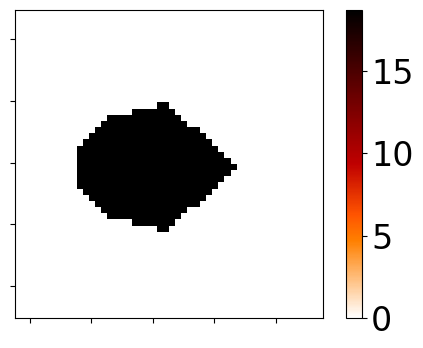

In [24]:
# Plot comparison of Fireline Intensity output
fig, ax = plt.subplots(1, figsize=(6,4))

# Raster form
im=ax.imshow(fi_image, extent=extent, cmap='gist_heat_r')
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

# plt.xlim([5,40])
# plt.ylim([10,40])

ax.set_xticklabels([]);ax.set_yticklabels([])
plt.show()

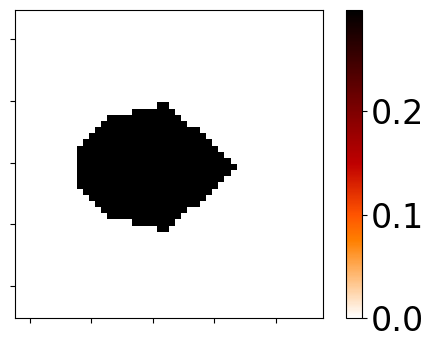

In [25]:
# Plot comparison of Flame Length output
fig, ax = plt.subplots(1, figsize=(6,4))

# Raster form
im=ax.imshow(fl_image, extent=extent, cmap='gist_heat_r')
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

# plt.xlim([5,40])
# plt.ylim([10,40])

ax.set_xticklabels([]);ax.set_yticklabels([])
plt.show()

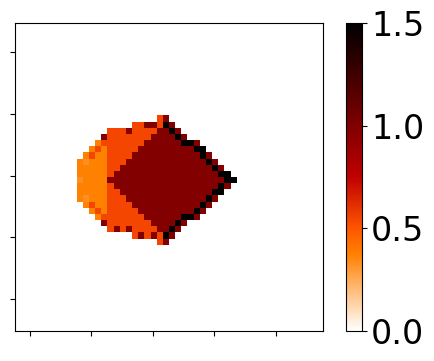

In [26]:
# Plot comparison of ROS output
fig, ax = plt.subplots(1, figsize=(6,4))

# Raster form
im=ax.imshow(ros_image, extent=extent, cmap='gist_heat_r')
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

# plt.xlim([5,40])
# plt.ylim([10,40])

ax.set_xticklabels([]);ax.set_yticklabels([])
plt.show()

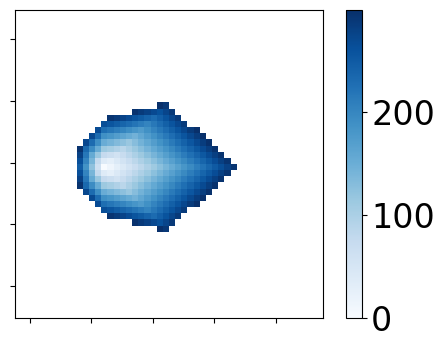

In [27]:
# Plot comparison of elapsed time output 
fig, ax = plt.subplots(1, figsize=(6,4))

# Raster form
im=ax.imshow(time_img, extent=extent, cmap='Blues')
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

# plt.xlim([5,40])
# plt.ylim([10,40])

ax.set_xticklabels([]);ax.set_yticklabels([])
plt.show()

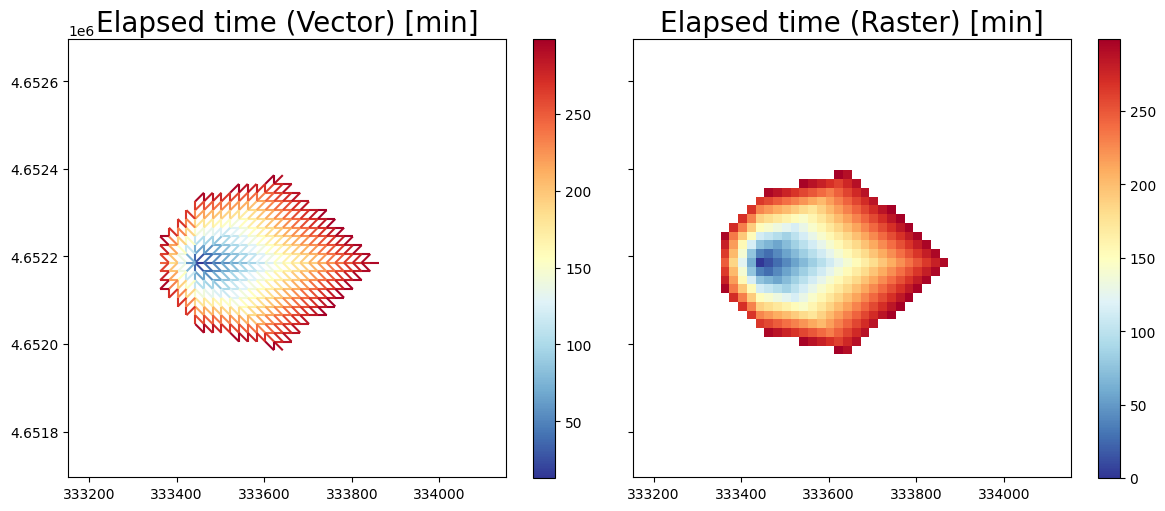

In [28]:
# Plot comparison of elapsed time output (Vector vs. raster)
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

# Vector form (Direct output from C2F)
edges_gdf.plot(ax=ax[0], column='time', cmap='RdYlBu_r', legend=True)

# Raster form
im=ax[1].imshow(time_img, extent=extent, cmap='RdYlBu_r')
fig.colorbar(im)

ax[0].set_title('Elapsed time (Vector) [min]', size=20)
ax[1].set_title('Elapsed time (Raster) [min]', size=20)

plt.tight_layout()
plt.show()

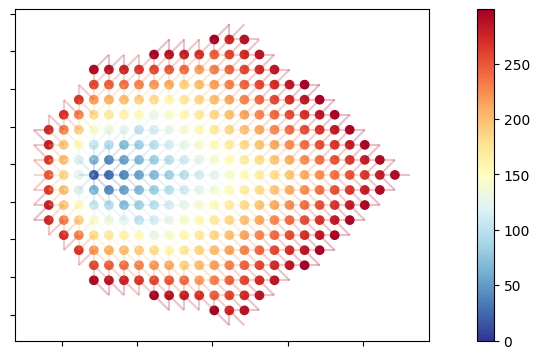

In [29]:
# Plot elapsed time output (with nodes and edges together)
fig, ax = plt.subplots(1, figsize=(10, 4))

# Vector form (Direct output from C2F)
nodes_gdf.plot(ax=ax, column='time', cmap='RdYlBu_r', vmin=0, legend=True)
edges_gdf.plot(ax=ax, column='time', cmap='RdYlBu_r', vmin=0, legend=False, alpha=0.25)

cbar.ax.tick_params(labelsize=20)  # Increase font size for colorbar ticks

plt.tight_layout()
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.show()

In [30]:
# nodes_gdf.set_crs(CRS_UTM).to_file(os.path.join(outfolder, 'nodes_gdf.shp'))
# edges_gdf.set_crs(CRS_UTM).to_file(os.path.join(outfolder, 'edges_gdf.shp'))

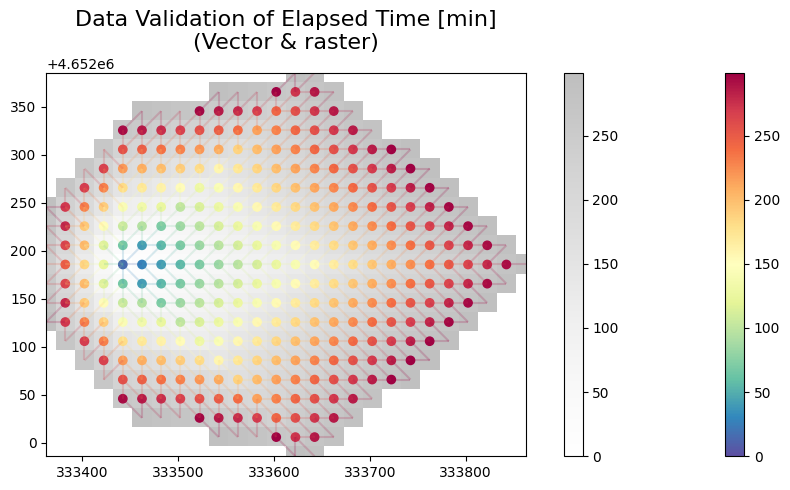

In [31]:
# Plot elapsed time with nodes and edges
fig, ax = plt.subplots(1, figsize=(10,5))

nodes_gdf.plot(ax=ax, column='time', cmap='Spectral_r', vmin=0, legend=True)
edges_gdf.plot(ax=ax, column='time', cmap='Spectral_r', vmin=0, legend=False, alpha=0.2)

im=ax.imshow(time, extent=extent, vmin=0, cmap='Greys', alpha=0.25)
fig.colorbar(im)

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

ax.set_title("Data Validation of Elapsed Time [min]\n(Vector & raster)", size=16)

plt.tight_layout()
plt.show()

## Automatic generation of fire potential polygons

##### 1. Spread direction

In [32]:
# Spread direction
fdir = flowdir(dem=time_img, dem_src=time_src, routing='d8',
               flats=-1, pits=-2, nodata_out=None,                                                                                                         
               dirmap=(64, 128, 1, 2, 4, 8, 16, 32))
            #    N, NE, E, SE, S, SW, W, NW

# Create PyFlwdir object
mask = ~np.isnan(time_img)

# Mask zero and negative values
fdir_bool = np.where(mask, fdir, np.nan)
fdir_mask = fdir>=0
fdir_arr = fdir.astype(float)
fdir_arr[fdir_arr > 128] = np.nan   # Ensure values are within expected range
fdir_arr[fdir_arr < 0] = np.nan     # Ensure values are within expected range

# Create object
flw_hydro = pyflwdir.from_array(fdir_arr.astype(np.uint8), 
                                 check_ftype=False, 
                                 transform=time_transform, 
                                 latlon=False, 
                                 mask=None)            
fdir_arr = flw_hydro.to_array(ftype='d8')

# Filter again
fdir_arr = fdir.astype(float)
fdir_arr[fdir_arr > 128] = np.nan   # Ensure values are within expected range
fdir_arr[fdir_arr < 0] = np.nan     # Ensure values are within expected range

# Add outlet as pit (explicitly)
# flw_hydro._pit = [4918, 4919, 4920, 5018, 5019, 5020, 5118, 5119, 5120]
# flw_hydro._pit = [4919, 5018, 5020, 5119]
# flw_hydro._pit = [5019]
flw_hydro._pit = [(ig_id-1)-height, ig_id-height, (ig_id+1)-height,
                  ig_id-1, ig_id, ig_id+1,
                  (ig_id-1)+height, ig_id+height, (ig_id+1)+height]

NoData value is None, no need for isnan check.


/var/folders/4q/2ngj48zn1b9cn0bd_kz6gg8c0000gn/T/ipykernel_62769/2511279707.py:18: RuntimeWarning: invalid value encountered in cast
  flw_hydro = pyflwdir.from_array(fdir_arr.astype(np.uint8),


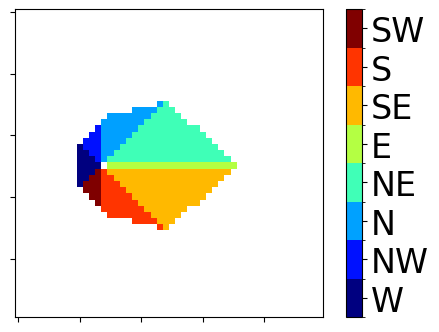

In [33]:
import matplotlib.colors as mcolors

# Define the spread direction values and corresponding orientations
dirmap = np.array([1, 2, 4, 8, 16, 32, 64, 128])
orientations = ['W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']

# Use the 'jet' colormap
cmap = plt.cm.jet

# Create a BoundaryNorm to ensure each value gets a unique color
boundaries = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256])
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

# Plot the raster data
fig, ax = plt.subplots(1, figsize=(6,4))
cax = ax.imshow(fdir_arr * fdir_mask, cmap=cmap, norm=norm)

# Create a colorbar with custom ticks and labels
cbar = fig.colorbar(cax, ticks=(boundaries[:-1] + boundaries[1:]) / 2)
cbar.ax.set_yticklabels(orientations)
cbar.ax.tick_params(labelsize=24) 

ax.set_xticklabels([]);ax.set_yticklabels([])

# Set plot title and show plot
# ax.set_title('Direction of Fire Spread', size=20)
plt.show()


#### 2. Cumulative fire spread paths

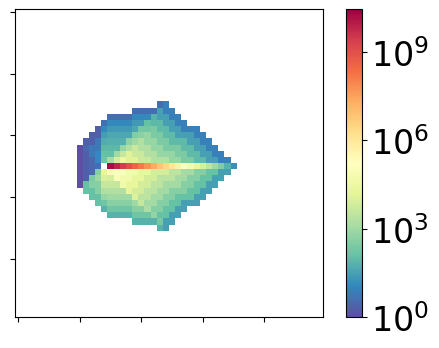

In [34]:
# Calculate cumulative fire spread paths
facc = flw_hydro.accuflux(fdir_arr, nodata=-9999, direction='up', count=3).astype(float)
facc[facc <= 0] = np.nan

# Plot
fig, ax = plt.subplots(1, figsize=(6,4))

im = ax.imshow(facc * fdir_mask, 
               zorder=1,
               cmap='Spectral_r',
               norm=matplotlib.cm.colors.LogNorm(1, np.nanmax(facc)),
               )

cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

ax.set_xticklabels([]);ax.set_yticklabels([])

# plt.title("Accumulation of fire spread paths", size=20)
# plt.savefig(os.path.join(outfolder, 'flow_accumulation.png'), dpi=300, bbox_inches='tight')
plt.show()

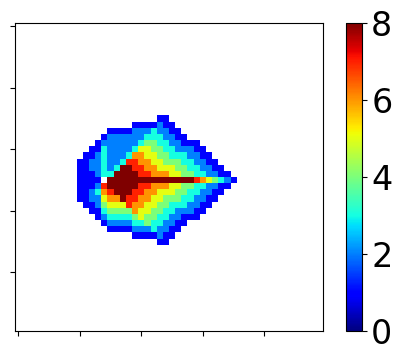

In [35]:
### Create spread order
stream_order = flw_hydro.stream_order().astype(float) * fdir_mask
stream_order[stream_order==0] = np.nan

# Plot
fig, ax = plt.subplots(1, figsize=(6,4))

im0=ax.imshow(stream_order, vmin=0, vmax=8, cmap='jet')

cbar = fig.colorbar(im0)
cbar.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

ax.set_xticklabels([]);ax.set_yticklabels([])

# plt.title("Degree of Fire Spread", size=20)

plt.show()
# plt.savefig(os.path.join(outfolder, 'stream_order.png'), dpi=300, bbox_inches='tight')
plt.close()

#### 3. Delineate basins as fire potential polygons

In [36]:
# Pfafstetter layer with a minimum subbasin area (10 / 10 / 1)
pf_depth = 4
upa_min = 10
n_largest_subbasins = 1
buffer = None

# Hillshade for visualization
ls = matplotlib.colors.LightSource(azdeg=115, altdeg=45)
hs = ls.hillshade(np.ma.masked_equal(time_img, 0), vert_exag=1e3)

def pf_subbasins(pf_depth, upa_min, n_largest_subbasins, title=None):
    
    # Delineate subbasins
    pfafbas2, idxs_out = flw_hydro.subbasins_pfafstetter(depth=pf_depth, upa_min=upa_min, n_largest_basins=n_largest_subbasins)

    # Vectorize into polygons
    gdf_pfaf2 = vectorize(pfafbas2.astype(np.int32), 0, flw_hydro.transform, name="pfaf2")        # Basin polygons
    gdf_out = gpd.GeoSeries(gpd.points_from_xy(*flw_hydro.xy(idxs_out))).set_crs(time_src.crs)     # Basin outlets (points)
    gdf_pfaf2["pfaf"] = gdf_pfaf2["pfaf2"] // 10
    basins_hydro = gdf_pfaf2
    basins_hydro['pfaf'] = gdf_pfaf2['pfaf']
    basins_hydro['pfaf2'] = gdf_pfaf2['pfaf2']

    # Clip outlet points to extent
    points_hydro = gpd.GeoDataFrame(geometry=gdf_out.to_crs(CRS_UTM))


    def remove_holes(polygon):
        if polygon.interiors:
            # Create a new polygon without interiors
            return Polygon(polygon.exterior)
        else:
            # Return the original polygon if no interiors
            return polygon

    # # Apply the function to remove holes
    basins_hydro['geometry'] = basins_hydro['geometry'].apply(lambda geom: remove_holes(geom) if geom.geom_type == 'Polygon' else geom)


    # Plot
    fig, ax = plt.subplots(1, figsize=(6,4))
    
    basins_hydro.plot(ax=ax, color='none',edgecolor='k', linewidth=1, zorder=1)
    points_hydro.plot(ax=ax, color='k',edgecolor='k', markersize=3, zorder=2)
    # ax.imshow(hs[38:62,12:42], cmap='Greys', zorder=0)
    im = ax.imshow(facc, extent=flw_hydro.extent, zorder=0,
                cmap='Spectral_r', alpha=0.8,
                norm=matplotlib.cm.colors.LogNorm(1, np.nanmax(facc)),
                # interpolation='bilinear'
                )


    ax.set_xticklabels([]);ax.set_yticklabels([])

    cbar = fig.colorbar(im,ax=ax)
    cbar.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

    # if title:
    #     plt.title(title, size=20)
    # else:
    #     plt.title('Depth{}_Area{}_Num{}'.format(pf_depth, upa_min, n_largest_subbasins), size=20)
    # plt.savefig(os.path.join(outfolder, 'basins_hydro_w_flwacc_upamin' + str(upa_min) + '.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return pfafbas2, basins_hydro, points_hydro

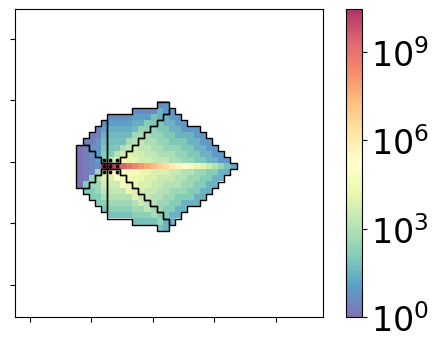

In [37]:
# Generate fire potential polygons
pfafbas2, basins_hydro, points_hydro = pf_subbasins(pf_depth=upa_min, n_largest_subbasins=n_largest_subbasins, upa_min=upa_min)

#### Step 5: Generate the fire flows and the directed network

In [38]:
# Compute networks
final_gdf = compute_intersecting_edges(basins_hydro, edges_gdf)                                  
network = create_suppression_network(final_df=final_gdf, 
                                    polys_gdf=basins_hydro, 
                                    sdi_slp=[],                    # Set to empty list to ignore
                                    metadata=None,
                                    directed=False, save=False)

100%|██████████| 6/6 [00:00<00:00, 20.13it/s]


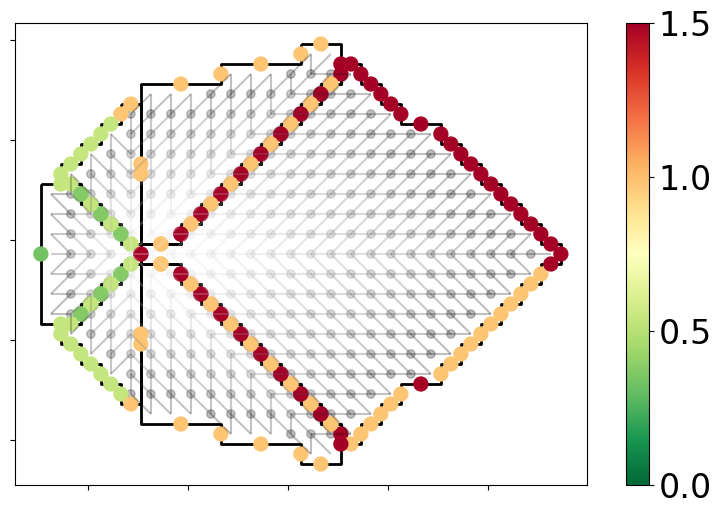

In [39]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Ensure the CRS of both GeoDataFrames match
if basins_hydro.crs != edges_gdf.crs:
    edges_gdf = edges_gdf.to_crs(basins_hydro.crs)

# Function to get individual edges (segments) of a polygon and their center points
def polygon_edges_and_centers(polygon):
    edges_centers = []
    if isinstance(polygon, Polygon):
        exterior_coords = list(polygon.exterior.coords)
        for i in range(len(exterior_coords) - 1):
            edge = LineString([exterior_coords[i], exterior_coords[i + 1]])
            center_point = edge.interpolate(0.5, normalized=True)
            edges_centers.append((edge, center_point))
    elif isinstance(polygon, MultiPolygon):
        for poly in polygon.geoms:  # Use .geoms to iterate over each Polygon in the MultiPolygon
            exterior_coords = list(poly.exterior.coords)
            for i in range(len(exterior_coords) - 1):
                edge = LineString([exterior_coords[i], exterior_coords[i + 1]])
                center_point = edge.interpolate(0.5, normalized=True)
                edges_centers.append((edge, center_point))
    return edges_centers

# Collect center points and their ROS values in a list
centers_list = []

# Process each basin to find its edges and compute ROS at center points
for idx, basin in basins_hydro.iterrows():
    edges_centers = polygon_edges_and_centers(basin['geometry'])
    for edge, center_point in edges_centers:
        # Find the nearest edge in edges_gdf
        nearest_edge = edges_gdf.iloc[edges_gdf.distance(center_point).idxmin()]
        ros_value = nearest_edge['ros']
        time_value = nearest_edge['time']
        centers_list.append({'geometry': center_point, 'ros': ros_value, 'time': time_value})

# Convert the list to a GeoDataFrame
centers_with_values = gpd.GeoDataFrame(centers_list, crs=basins_hydro.crs)

# Plot the results with colored center points
fig, ax = plt.subplots(1, figsize=(10, 6))

# Normalize the ROS values for coloring
norm = Normalize(vmin=0, vmax=centers_with_values['ros'].max())
cmap = plt.get_cmap('RdYlGn_r')

# Plot each center point with the corresponding color
centers_with_values['color'] = centers_with_values['ros'].apply(lambda x: cmap(norm(x)))
centers_with_values.plot(ax=ax, color=centers_with_values['color'], vmin=0, markersize=100, zorder=2)
edges_gdf.plot(ax=ax, column='time', cmap='Greys', legend=False, alpha=0.25, vmin=0)
nodes_gdf.plot(ax=ax, column='time', cmap='Greys', legend=False, alpha=0.25, vmin=0)

# Add a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar to work
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks
cbar.set_ticks([0, 0.5, 1, centers_with_values['ros'].max()])

# Plot the basins for reference
basins_hydro.boundary.plot(ax=ax, edgecolor='black', linewidth=2, zorder=0)
ax.set_xticklabels([]);ax.set_yticklabels([])

# Set plot title and show plot
# ax.set_title('Polygon-polygon penetration ROS [m/min]', size=30)
plt.show()

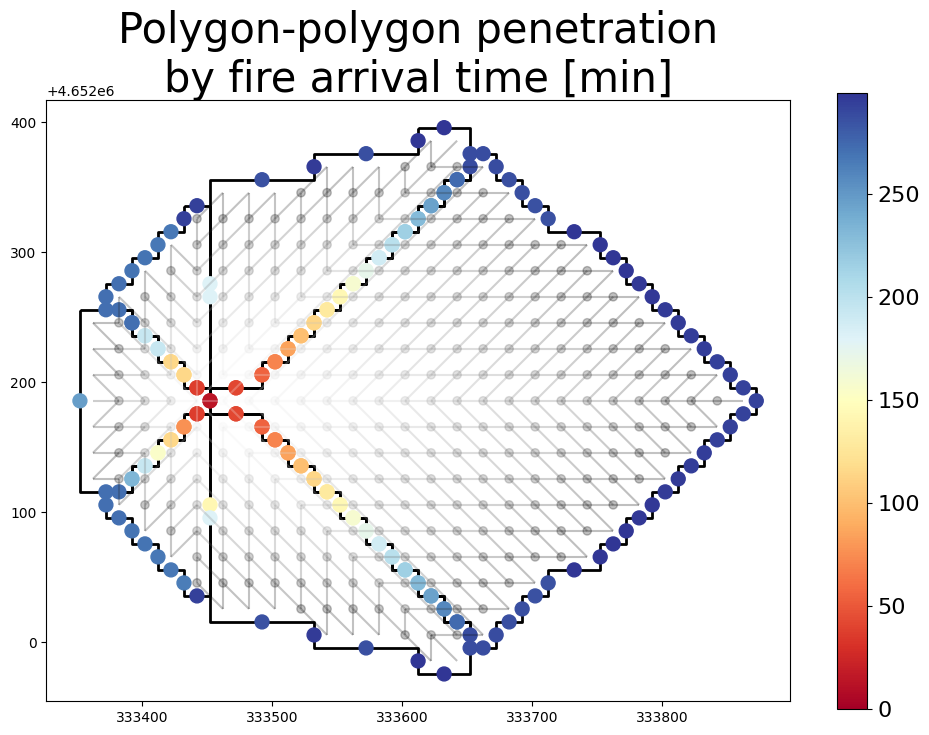

In [40]:
#####
# Plot the results with colored center points
fig, ax = plt.subplots(1, figsize=(12, 8))

# Normalize the Time values for coloring
norm = Normalize(vmin=0, vmax=centers_with_values['time'].max())
cmap = plt.get_cmap('RdYlBu')

# Plot each center point with the corresponding color
centers_with_values['color'] = centers_with_values['time'].apply(lambda x: cmap(norm(x)))
centers_with_values.plot(ax=ax, color=centers_with_values['color'], vmin=0, markersize=100, zorder=2)
edges_gdf.plot(ax=ax, column='time', cmap='Greys', legend=False, alpha=0.25)
nodes_gdf.plot(ax=ax, column='time', cmap='Greys', legend=False, alpha=0.25)

# Add a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar to work
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=16)  # Increase font size for colorbar ticks

# Plot the basins for reference
basins_hydro.boundary.plot(ax=ax, edgecolor='black', linewidth=2, zorder=0)

# Set plot title and show plot
ax.set_title('Polygon-polygon penetration\nby fire arrival time [min]', size=30)
plt.show()

/var/folders/4q/2ngj48zn1b9cn0bd_kz6gg8c0000gn/T/ipykernel_62769/430675941.py:39: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(network, pos=node_positions,
/var/folders/4q/2ngj48zn1b9cn0bd_kz6gg8c0000gn/T/ipykernel_62769/430675941.py:39: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(network, pos=node_positions,


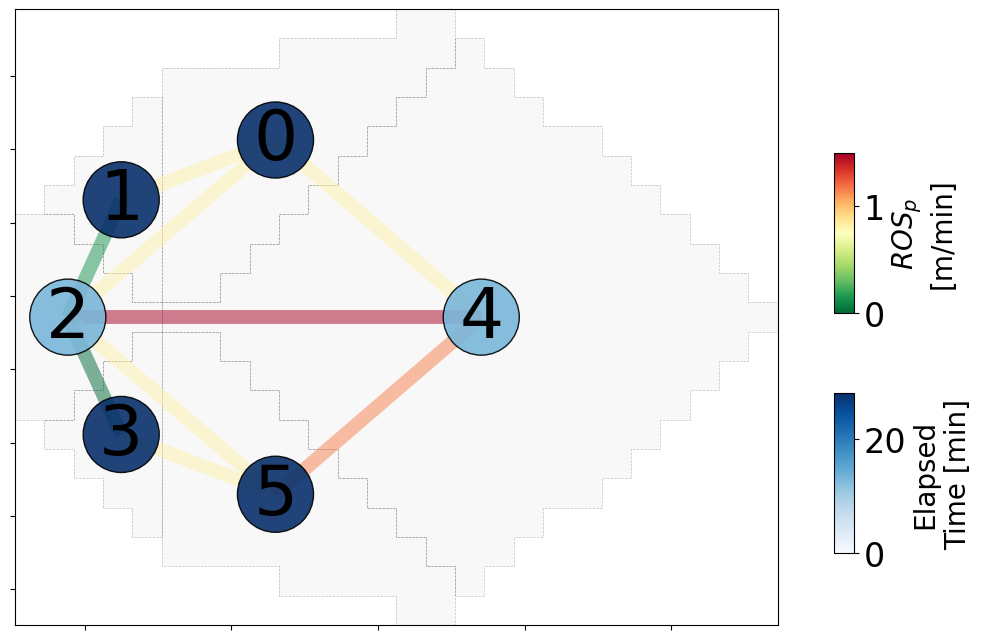

In [41]:
### REVISED (12/9)
# Plot suppression network
boundaries='time' 
attribute='att'
attribute_label="$ROS_p$\n[m/min]"
directed=False
polys_gdf = basins_hydro


# Colormaps for visualization
cmap_connections = plt.get_cmap('RdYlGn_r')     
cmap_time = plt.get_cmap('Blues')                                    # Time (Nodes and boundaries)

# Create network
network = nx.DiGraph(network) if directed else nx.Graph(network)

### Plot
fig, ax = plt.subplots(1, figsize=(10,8))

# Plot 2: Main polygons
polys_gdf.plot(ax=ax, color='none', linewidths=.5, edgecolor='k', alpha=0.25, linestyle='--')
basins_hydro.plot(ax=ax, color='grey', edgecolor='none', alpha=0.05)

# Plot 2-1: Draw nodes
node_positions = nx.get_node_attributes(network, 'pos')

nx.draw_networkx_nodes(network, pos=node_positions, node_size=3000, 
                        cmap=cmap_time, 
                        vmin=0,
                        vmax=max(list(nx.get_node_attributes(network, 'time').values())),
                        node_color=list(nx.get_node_attributes(network, 'time').values()),
                        alpha=0.9, edgecolors='black', linewidths=1, label=True,
                        ax=ax)
nx.draw_networkx_labels(network, pos=node_positions, font_size=50)

# Plot 2-2: Draw edges
max_ros = max(list(nx.get_edge_attributes(network, 'att').values()))
weights = [10*(network[u][v]['att'] / max_ros) for u, v in network.edges()]
nx.draw_networkx_edges(network, pos=node_positions, 
                        width=10,
                        edge_color=list(nx.get_edge_attributes(network, attribute).values()),
                        edge_cmap=cmap_connections,
                        connectionstyle='arc3,rad=0.3', 
                        arrowsize=20,
                        alpha=0.5,
                        ax=ax)

# Visualization details
# Add ROS color bar
cax1 = fig.add_axes([0.95, 0.5, 0.02, 0.2])  # [left, bottom, width, height]
norm1 = Normalize(vmin=0, vmax=max(list(nx.get_edge_attributes(network, attribute).values())))
scalar_map1 = ScalarMappable(cmap=cmap_connections, norm=norm1)
scalar_map1.set_array(list(nx.get_edge_attributes(network, attribute).values()))
cbar1 = fig.colorbar(scalar_map1, cax=cax1)
cbar1.set_label(attribute_label, size=20)
cbar1.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

# Add Arrival Time color bar
cax2 = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
norm2 = Normalize(vmin=0, vmax=max(list(nx.get_node_attributes(network, 'time').values())))
scalar_map2 = ScalarMappable(cmap=cmap_time, norm=norm2)
scalar_map2.set_array(list(nx.get_node_attributes(network, 'time').values()))
cbar2 = fig.colorbar(scalar_map2, cax=cax2)
cbar2.set_label('Elapsed\nTime [min]', size=20)
cbar2.ax.tick_params(labelsize=24)  # Increase font size for colorbar ticks

# ctx.add_basemap(ax=ax, crs=crs, source=ctx.providers.CartoDB.Positron)
# ax.add_artist(ScaleBar(dx=1, label="Scale", location="lower left", label_loc="top", scale_loc="bottom"))

# Set extent boundaries
xmin, ymin, xmax, ymax = polys_gdf.buffer(0.001).total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=16)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.show()